In [1]:
# step one
import sys, os
sys.path.append(os.path.abspath(".."))
from src.modeling import train_and_track_models

In [2]:
#  Step 2: Define Paths and Parameters
data_path = "../data/processed/features_with_target.csv"   
target_col = "is_high_risk"       # Proxy target created in Task 4
id_col = "CustomerId"
model_dir = "../models"
report_dir = "../reports"
mlflow_experiment_name = "credit-risk-models"
random_state = 42


In [3]:
#  Step 3: Train Models & Track with MLflow
best_model_name, best_model, best_f1_score = train_and_track_models(
    data_path=data_path,
    target_col=target_col,
    id_col=id_col,
    model_dir=model_dir,
    report_dir=report_dir,
    mlflow_experiment_name=mlflow_experiment_name,
    random_state=random_state
)


Data loaded: 3742 rows, 14 cols
Missing values per column before processing:
Amount_sum                 0
Amount_mean                0
Amount_std               712
Amount_count               0
txn_year_nunique           0
txn_month_nunique          0
txn_dayofweek_nunique      0
txn_hour_nunique           0
ProviderId                 0
ProductCategory            0
ChannelId                  0
PricingStrategy            0
dtype: int64
Missing values detected and will be handled via imputation in pipeline.
Numerical columns: ['Amount_sum', 'Amount_mean', 'Amount_std', 'Amount_count', 'txn_year_nunique', 'txn_month_nunique', 'txn_dayofweek_nunique', 'txn_hour_nunique', 'PricingStrategy']
Categorical columns: ['ProviderId', 'ProductCategory', 'ChannelId']
Train size: 2993, Test size: 749

Training model: logistic_regression
Best Params: {'clf__C': 0.01}
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.54      0.67       463
     

/home/nurye/Desktop/10_Academy/week_5/Credit-Risk-Probability-Model-for-Alternative-Data/CS-venv/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2025/06/27 15:00:43 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Best Params: {'clf__learning_rate': 0.1, 'clf__max_depth': 3, 'clf__n_estimators': 200}
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.63      0.74       463
           1       0.59      0.88      0.71       286

    accuracy                           0.72       749
   macro avg       0.75      0.76      0.72       749
weighted avg       0.78      0.72      0.73       749

Confusion Matrix:
 [[290 173]
 [ 33 253]]
Accuracy: 0.7250
Precision: 0.5939
Recall: 0.8846
F1 Score: 0.7107
ROC AUC: 0.8211

Best model: random_forest with F1 score: 0.7124


Registered model 'random_forest_final' already exists. Creating a new version of this model...
Created version '6' of model 'random_forest_final'.


In [7]:
#  Step 4: Summary
print(f" Best Model: {best_model_name}")
print(f" Best F1 Score: {best_f1_score:.4f}")

 Best Model: random_forest
 Best F1 Score: 0.7124


| Component            | Description                                                                      |
| -------------------- | -------------------------------------------------------------------------------- |
|  Data Shape         | 3,742 rows × 14 columns                                                          |
|  Target Variable    | `is_high_risk` proxy target from Task 4                                          |
|  Models Trained     | Logistic Regression, Random Forest, XGBoost                                      |
|  Preprocessing      | Full pipeline: Imputation + Scaling (numeric), Imputation + OneHot (categorical) |
|  Evaluation Metrics | Accuracy, Precision, Recall, F1-Score, ROC AUC                                   |
|  Cross-Validation   | 5-Fold GridSearchCV                                                              |
|  Best Model         | **Random Forest** with **F1 Score = 0.704**                                      |
|  MLflow Tracking    | All experiments tracked under `credit-risk-models`                               |
|  Model Registry     | Best model registered as **`random_forest_final`**                               |
|  Artifacts Saved    | Model .pkl, ROC curve, reports saved to `../models/` and `../reports/`           |


<Figure size 1200x800 with 0 Axes>

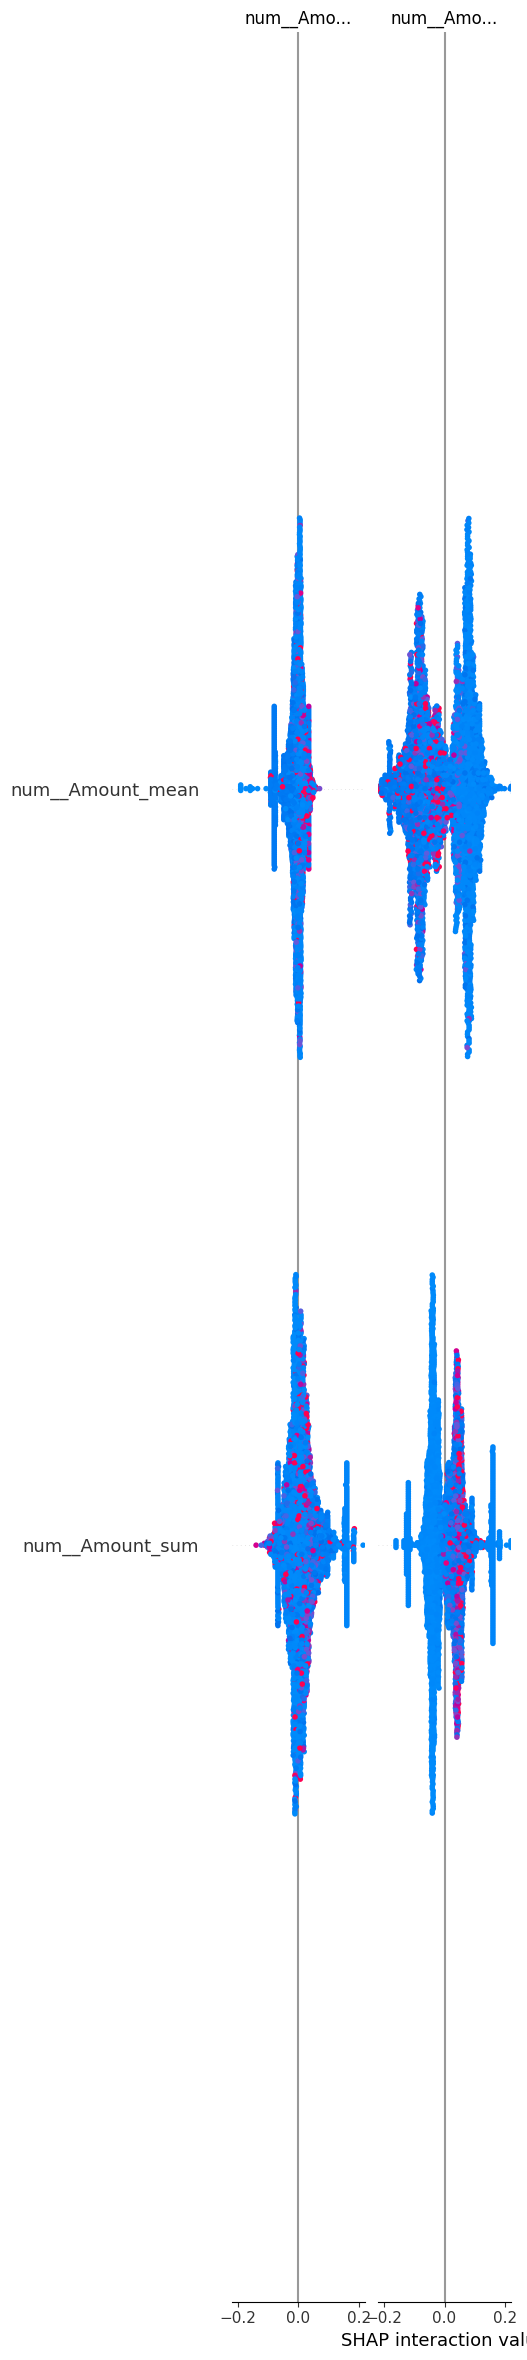

In [2]:
import shap
import joblib
import pandas as pd
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
import warnings

# Silence SHAP FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning, message="The NumPy global RNG was seeded.*")

# Load pipeline
pipeline = joblib.load("../models/random_forest_model.pkl")
model = pipeline.named_steps["clf"]
preprocessor = pipeline.named_steps["preprocessor"]

# Load and preprocess data
df = pd.read_csv("../data/processed/features_with_target.csv")
X_raw = df.drop(columns=["CustomerId", "is_high_risk"])
X_transformed = preprocessor.transform(X_raw)
if sparse.issparse(X_transformed):
    X_transformed = X_transformed.toarray()

# Get feature names
feature_names = preprocessor.get_feature_names_out()
X_transformed_df = pd.DataFrame(X_transformed, columns=feature_names)

# SHAP explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_transformed_df)

# Select SHAP values for class 1
shap_vals = shap_values[1] if isinstance(shap_values, list) else shap_values

# Fix shape mismatch if needed
n_shap_cols = shap_vals.shape[1]
n_feat_cols = X_transformed_df.shape[1]
if n_shap_cols > n_feat_cols:
    shap_vals = shap_vals[:, :n_feat_cols]

# Plot SHAP bar plot (global importance)
plt.figure(figsize=(12, 8))
shap.summary_plot(
    shap_vals,
    X_transformed_df,
    feature_names=feature_names[:n_shap_cols],
    plot_type="bar",  # bar plot shows global feature importance
    max_display=30,   # adjust as needed
    show=False
)

# Save to file
plt.savefig("shap_summary_bar_plot.png", bbox_inches="tight", dpi=300)
plt.show()

###  expaling the result

| Feature                                                                                     | SHAP Interaction Patterns                   |
| ------------------------------------------------------------------------------------------- | ------------------------------------------- |
| `num__Amount_mean`                                                                          | Two strong vertical clouds around 0         |
| `num__Amount_sum`                                                                           | Similar pattern; strong vertical dispersion |
| Top interaction columns are truncated (`num__Amo...`) but likely relate to amount features. |                                             |


###  **How to Interpret This SHAP Interaction Plot**

1. **Axes Meaning:**

   * **Y-axis**: The features ranked by their average interaction strength.
   * **X-axis**: The SHAP interaction value (i.e., how much two features together contribute to the prediction).
   * **Dots**: Each dot is a data point (customer/sample).
   * **Color**: Red = higher value of the feature; Blue = lower value.

---

###  **Key Observations & Interpretations**

####  `num__Amount_mean`:

* This feature is among the top contributors.
* **Dense cloud around 0**: Suggests most values don’t heavily sway the prediction.
* **Spread both sides**: In some samples, this feature interacts positively or negatively with others (likely `num__Amount_sum` or similar).

**Interpretation**: The average transaction amount (`num__Amount_mean`) has meaningful but nuanced interaction with another feature (possibly total amount), suggesting some combinations of transaction patterns matter.

---

####  `num__Amount_sum`:

* Also one of the most important features by interaction.
* **Vertical spread** means it strongly interacts with some other feature to influence prediction positively or negatively.
* Likely this interaction distinguishes **high spenders** vs **moderate ones**.

 **Interpretation**: The total amount spent is a key driver in whether the model predicts "high risk", **especially when combined with another related feature** (possibly frequency or average amount).

---

###  Strategic Insight

This SHAP interaction plot reveals:

* Risk is not just driven by single features like "amount" but rather **interactions between features** (e.g., someone who spends a lot *and* has high average transaction = higher risk).
* You can prioritize these features (`num__Amount_sum`, `num__Amount_mean`) in feature selection, rule-based strategies, or customer segmentation.


###  What You Can Do Next

1. **Use waterfall plots** to explain individual decisions.
2. **Use `shap.dependence_plot()`** to see the interaction in detail:

   ```python
   shap.dependence_plot(("num__Amount_sum", "num__Amount_mean"), shap_values[1], X_transformed_df)
   ```
3. **Include a business explanation**:

   * “High total and average transaction amounts in combination signal greater credit risk.”
   * Useful for non-technical stakeholders.
